In [1]:
from sklearn.model_selection import train_test_split
from os import listdir, getcwd
from os.path import join
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (20, 20)

Using TensorFlow backend.


In [2]:
from lib import augmentations
from lib import unet

In [3]:
DATA_DIR = join(getcwd(), 'data')
TRAIN_DIR = join(DATA_DIR, 'train')
MASK_DIR = join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = listdir(TRAIN_DIR)
MASK_IMAGE_LIST = listdir(MASK_DIR)
ASPECT_RATIO = 1280 / 1918

In [4]:
train_images, test_images, train_masks, test_masks = train_test_split(TRAIN_IMAGE_LIST, 
                                                                      MASK_IMAGE_LIST, 
                                                                      test_size=0.2)
train_images, validation_images, train_masks, validation_masks = train_test_split(train_images,
                                                                                  train_masks,
                                                                                  test_size=0.25)

In [5]:
def square_it(img, mask):
    
    if img.shape[2] != img.shape[1]:
        
        diff1 = int(np.ceil((img.shape[2]-img.shape[1])/2))
        diff2 = int(np.floor((img.shape[2]-img.shape[1])/2))

        zero_img1 = np.zeros((img.shape[0],diff1,img.shape[2],img.shape[3]))
        zero_img2 = np.zeros((img.shape[0],diff2,img.shape[2],img.shape[3]))

        img_tmp = np.concatenate((zero_img1,img),axis=1)
        new_img = np.concatenate((img_tmp, zero_img2),axis=1)

        mask_tmp = np.concatenate((zero_img1,mask),axis=1)
        new_mask = np.concatenate((mask_tmp, zero_img2),axis=1)
    
        return new_img, new_mask
    
    else:
        
        return img, mask

In [9]:
def image_generator_function(images_dir, masks_dir, images, masks, batch_size, img_width = None, num_colors = 256):
    
    '''
    images: Array of image names
    masks: Array of mask names
    batch_size: The number of images to be consider in one batch.
    num_colors = target number of colors for kmeans algorithm. (Default = 256)
    img_width: The width to which the original image is resized while maintaining aspect ratio. Does not resize if no parameters passed.
    '''
    
    img_dim = [int(ASPECT_RATIO * img_width), img_width] if img_width is not None else None
    
    while True:
        random_indices = np.random.choice(len(images), batch_size)
        i = []
        m = []
        
        for index in random_indices:
            img = load_img(join(images_dir, images[index]))
            img_array = img_to_array(img) / 255
            i.append(img_array)
            mask = load_img(join(masks_dir, masks[index]))
            mask_array = img_to_array(mask) / 255
            m.append(mask_array)
            
        yield np.array(i), np.array(m)

In [10]:
train_generator = image_generator_function(TRAIN_DIR, MASK_DIR, train_images, train_masks, 5, 128, 16)
img_tmp, mask_tmp = next(train_generator)
img, mask = augmentations.random_augmentation(img_tmp, mask_tmp)
img_c = []
for i in img:
    img_c.append(augmentations.color_quantize(i, 16))
img = np.array(img_c)
img, mask = square_it(img, mask)

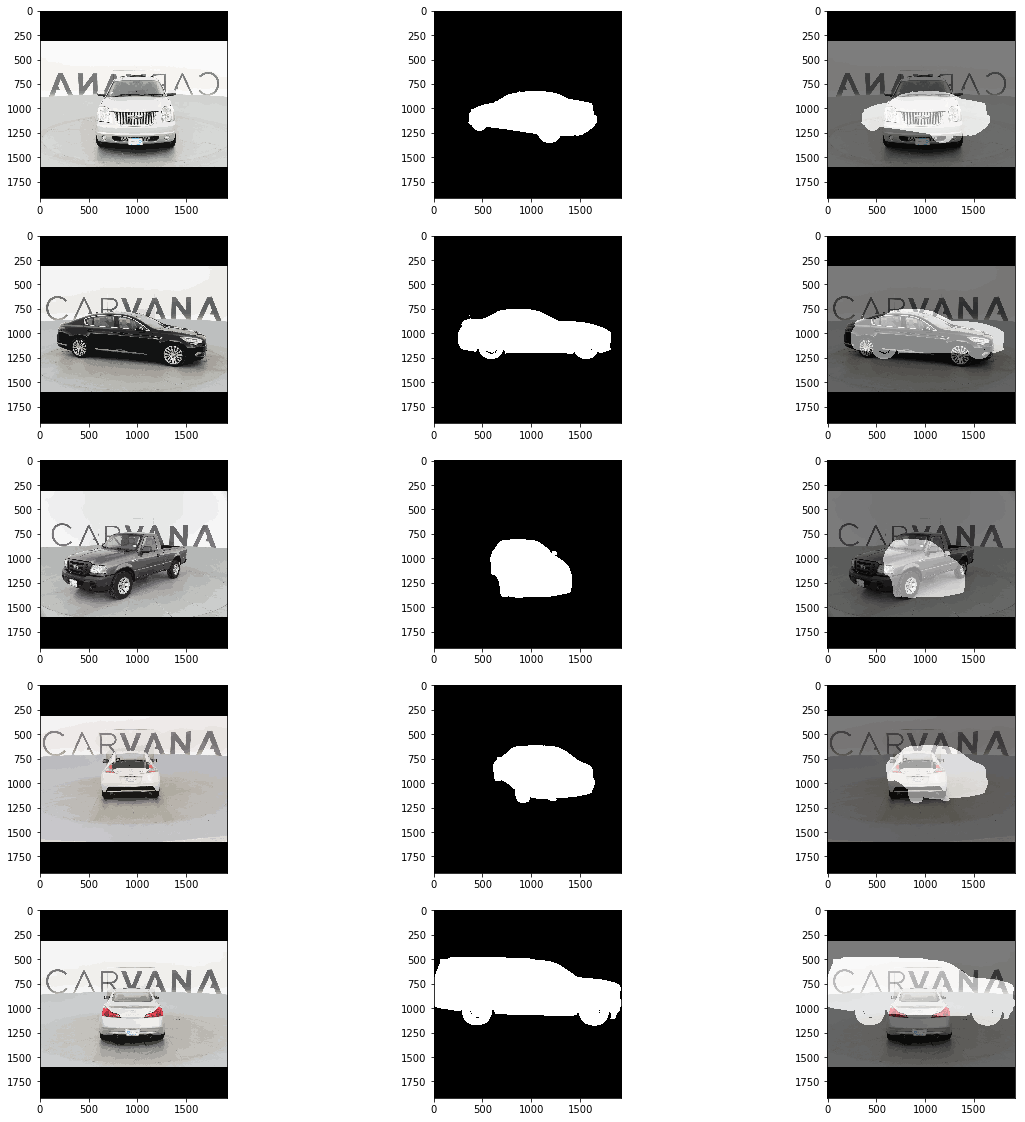

In [11]:
plot = 1
for i in range(img.shape[0]):
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(img[i])
    plot += 1
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(mask[i])
    plot += 1
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(img[i])
    plt.imshow(mask[i], alpha=0.5)
    plot += 1
plt.show()